In [1]:
import tensorflow as tf
from scipy.io import loadmat

In [2]:
tf.__version__

'2.3.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
# Run this cell to load the dataset

train = loadmat('../../coursera_data/data/train_32x32.mat')
test = loadmat('../../coursera_data/data/test_32x32.mat')

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Extract the training and testing images and labels separately from the train and test dictionaries

X_train=train['X'] /255
X_train=np.moveaxis(X_train,-1,0)
y_train=train['y']

y_train[y_train == 10] = 0 # change label '10' to '0', it produces errors otherwise.

X_test=test['X'] /255
X_test=np.moveaxis(X_test,-1,0)
y_test=test['y']
y_test[y_test == 10] = 0 # change label '10' to '0', it produces errors otherwise.


print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (73257, 32, 32, 3)
y_train shape:  (73257, 1)
X_test shape:  (26032, 32, 32, 3)
y_test shape:  (26032, 1)


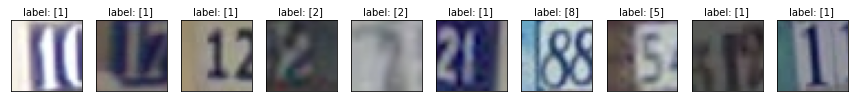

In [6]:
# Select a random sample of images and corresponding labels from the dataset (at least 10), 
# and display them in a figure.

# random.seed(10)
# print(random.random())

fig, axes=plt.subplots(1,10, figsize=(15,80))

total_image_num = X_train.shape[0]
random_inx = np.random.choice(total_image_num, 10) # 10 random number out of random_image_num
random_images = X_train[random_inx, ...]
random_labels = y_train[random_inx, ...]

# title=fig.suptitle('Random images from dataset (RAW)', fontsize=14)   
# fig.tight_layout()
# title.set_y(0.2)

for i, label in enumerate(random_labels):
    axes[i].imshow(random_images[i, ...])
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].text(5, -3, f'label: {label}')
plt.show()

In [7]:
# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
# Hint: retain the channel dimension, which will now have size 1.

X_train_gray=np.mean(X_train, axis=-1, keepdims=True)
X_test_gray=np.mean(X_test, axis=-1, keepdims=True)

print("X_train_gray shape: ", X_train_gray.shape)
print("y_train shape: ", y_train.shape)
print("X_test_gray shape: ", X_test_gray.shape)
print("y_test shape: ", y_test.shape)

X_train_gray shape:  (73257, 32, 32, 1)
y_train shape:  (73257, 1)
X_test_gray shape:  (26032, 32, 32, 1)
y_test shape:  (26032, 1)


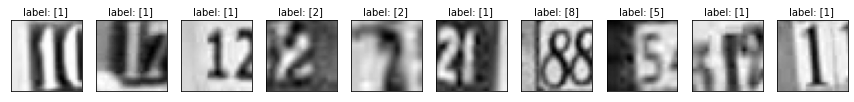

In [8]:
# Select a random sample of the grayscale images and corresponding labels 
# from the dataset (at least 10), and display them in a figure.

random_images_gray = X_train_gray[random_inx, ...]

fig, axes=plt.subplots(1,10, figsize=(15,80))

for i, label in enumerate(random_labels):
    axes[i].imshow(np.squeeze(random_images_gray[i, ...]),cmap='gray') # np.squeeze removes axes of length 1 
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].text(5, -3, f'label: {label}')

plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def my_model(input_shape):
    model=Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Flatten(),
        Dense(10, activation='softmax')      
    ])
    return model

model=my_model(X_train_gray[0, ...].shape)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32, 64)        128       
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 64)        4160      
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                655370    
Total params: 659,658
Trainable params: 659,658
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile and train the model (we recommend a maximum of 30 epochs), making use of both training 
# and validation sets during the training run.
# Your model should track at least one appropriate metric, and use at least two callbacks 
# during training, one of which should be a ModelCheckpoint callback.
# As a guide, you should aim to achieve a final categorical cross entropy training loss 
# of less than 1.0 (the validation loss might be higher).
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
# Compute and display the loss and accuracy of the trained model on the test set.

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Callback 1: training callback
class TrainingCallback(Callback):   
    def on_train_begin(self, logs=None):
        print("Starting training ....")
    def on_train_end(self, logs=None):
        print("Finished training!")

# Callback 2: checkpoint callback
checkpoint_path= 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only = True, verbose=1)

# Callback 3: early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

In [13]:
history_mlp = model.fit(x=X_train_gray, y=y_train, epochs=10,validation_data=(X_test_gray, y_test), 
          batch_size=32, callbacks=[TrainingCallback(), checkpoint, early_stopping])

Starting training ....
Epoch 1/10
2284/2290 [============================>.] - ETA: 0s - loss: 2.1689 - accuracy: 0.2508
Epoch 00001: val_loss improved from inf to 2.08426, saving model to model_checkpoints/checkpoint
2290/2290 [==============================] - 10s 4ms/step - loss: 2.1687 - accuracy: 0.2509 - val_loss: 2.0843 - val_accuracy: 0.3160
Epoch 2/10
2279/2290 [============================>.] - ETA: 0s - loss: 2.0882 - accuracy: 0.3171
Epoch 00002: val_loss did not improve from 2.08426
2290/2290 [==============================] - 10s 4ms/step - loss: 2.0881 - accuracy: 0.3172 - val_loss: 2.0860 - val_accuracy: 0.3395
Epoch 3/10
2289/2290 [============================>.] - ETA: 0s - loss: 2.0665 - accuracy: 0.3293
Epoch 00003: val_loss did not improve from 2.08426
2290/2290 [==============================] - 10s 4ms/step - loss: 2.0665 - accuracy: 0.3294 - val_loss: 2.0989 - val_accuracy: 0.3225
Epoch 4/10
2277/2290 [============================>.] - ETA: 0s - loss: 2.0547 - a

<AxesSubplot:>

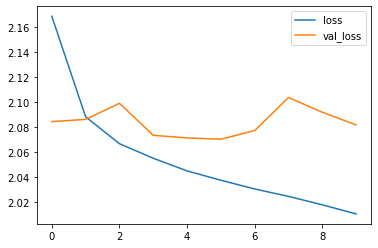

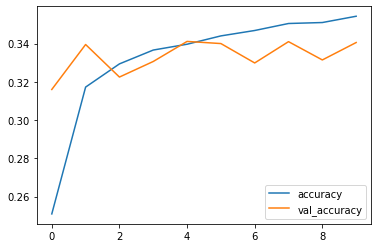

In [14]:
import pandas as pd
df_mlp = pd.DataFrame(history_mlp.history)
df_mlp.plot(y=['loss','val_loss'])
df_mlp.plot(y=['accuracy','val_accuracy'])


# ###

# import matplotlib.pyplot as plt

# plt.plot(history_mlp.history['loss'])
# plt.plot(history_mlp.history['val_loss'])
# plt.title('Loss vs epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training','Validation'],loc='upper right')
# plt.show()

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [38]:
def cnn_model(input_shape, dr_rate):
    model = Sequential([
        Conv2D(filters=32, input_shape=input_shape, kernel_size=(3,3), activation = 'relu'),
        Dropout(dr_rate),
        Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
        Dropout(dr_rate),
        Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
        Dropout(dr_rate),
        MaxPooling2D(pool_size=(4,4)),
        BatchNormalization(),
        Flatten(),
        Dropout(dr_rate),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax')
    ])
    return model

model_cnn = cnn_model(X_train_gray[0, ...].shape, 0.3)

In [39]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 8)         1160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 8)          

In [40]:
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Callback 2-2: checkpoint callback for cnn model
checkpoint_path2 = 'model_checkpoint/checkpoint2'
checkpoint2 = ModelCheckpoint(filepath = checkpoint_path2, save_weights_only = True, save_best_only = True, verbose=1)

In [42]:
history_cnn = model_cnn.fit(x=X_train_gray, y=y_train, epochs=10,validation_data=(X_test_gray, y_test), 
          batch_size=32, callbacks=[TrainingCallback(), checkpoint2, early_stopping])

Starting training ....
Epoch 1/10
2290/2290 [==============================] - ETA: 0s - loss: 1.6436 - accuracy: 0.4388
Epoch 00001: val_loss improved from inf to 1.06415, saving model to model_checkpoint/checkpoint2
2290/2290 [==============================] - 21s 9ms/step - loss: 1.6436 - accuracy: 0.4388 - val_loss: 1.0642 - val_accuracy: 0.6592
Epoch 2/10
2289/2290 [============================>.] - ETA: 0s - loss: 0.7334 - accuracy: 0.7711
Epoch 00002: val_loss improved from 1.06415 to 0.83017, saving model to model_checkpoint/checkpoint2
2290/2290 [==============================] - 11s 5ms/step - loss: 0.7334 - accuracy: 0.7711 - val_loss: 0.8302 - val_accuracy: 0.7320
Epoch 3/10
2282/2290 [============================>.] - ETA: 0s - loss: 0.6294 - accuracy: 0.8042
Epoch 00003: val_loss improved from 0.83017 to 0.68056, saving model to model_checkpoint/checkpoint2
2290/2290 [==============================] - 11s 5ms/step - loss: 0.6293 - accuracy: 0.8042 - val_loss: 0.6806 - val

<AxesSubplot:>

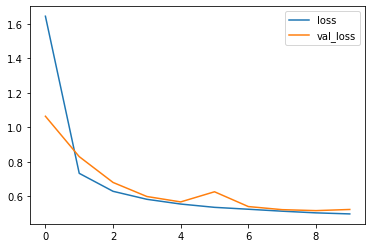

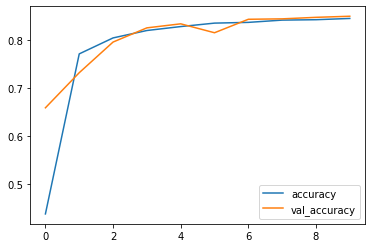

In [43]:
df_cnn = pd.DataFrame(history_cnn.history)
df_cnn.plot(y=['loss','val_loss'])
df_cnn.plot(y=['accuracy','val_accuracy'])

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
model.load_weights()